In [ ]:
"""
This notebook takes a stack, a neurotrace blue-nissl pair and a region bounding box,
generates the intensity histograms, mapping curve and corresponding images.
"""

In [1]:
import os, sys

from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import DataFrame

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


In [2]:
stack = 'MD657'
_, sec2fn = DataManager.load_sorted_filenames(stack)
first_sec, last_sec = DataManager.load_cropbox(stack)[4:]

In [4]:
def match_histogram(source, template):
    """
    Returns: 
        s_values (array): unique source values
        interp_t_values (array): unique destination values
    """
    
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return s_values, interp_t_values

In [6]:
from skimage.exposure import rescale_intensity

In [28]:
# for nissl_sec, ntb_sec in compare_pairs[34:35]:
for nissl_sec, ntb_sec in [(149,150)]:
    
    ntb_matched_values_all_examples_one_section = []
    region_bboxes_all_examples_one_section = []
    
    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=nissl_sec, version='cropped')
    w, h = metadata_cache['image_shape'][stack]

    t = time.time()
    ntb_im = DataManager.load_image(stack=stack, section=ntb_sec, version='cropped', resol='lossless')
    sys.stderr.write('Load NTB: %.2f seconds.\n' % (time.time()-t))

    t = time.time()
    nissl_im = DataManager.load_image(stack=stack, section=nissl_sec, version='cropped', resol='lossless')
    sys.stderr.write('Load Nissl: %.2f seconds.\n' % (time.time()-t))

#     h, w = nissl_im.shape[:2]
#     for region_id in range(3):
#         while True:
#             region1_w = 5000
#             region1_h = 5000
#             region1_x = np.random.randint(0, w - region1_w, 1)[0]
#             region1_y = np.random.randint(0, h - region1_h, 1)[0]
# #             print region1_x, region1_y, region1_w, region1_h
            
#             tb_region1_xmin = region1_x / 32
#             tb_region1_xmax = (region1_x + region1_w) / 32
#             tb_region1_ymin = region1_y / 32
#             tb_region1_ymax = (region1_y + region1_h) / 32
            
#             if np.all(np.r_[nissl_tb_mask[tb_region1_ymin, tb_region1_xmin],
#             nissl_tb_mask[tb_region1_ymin, tb_region1_xmax],
#             nissl_tb_mask[tb_region1_ymax, tb_region1_xmin],
#             nissl_tb_mask[tb_region1_ymax, tb_region1_xmax]]):
#                 break
    
    for region_id in range(1):
        region1_x = 233 * 32
        region1_y = 299 * 32
        region1_w = 124 * 32
        region1_h = 98 * 32
    
        ntb_blue_region1 = ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 2]
        
        # Checked a few sections, maximal intensity value in blue channel is less than 5000.
        ntb_blue_bins = np.arange(5001)
        ntb_blue_hist = np.histogram(ntb_blue_region1.flatten(), bins=np.r_[ntb_blue_bins, 5001])[0]
        
        ntb_blue_inv_bins = np.arange(5001)
        ntb_blue_inv_hist = np.histogram(5000 - ntb_blue_region1.flatten(), bins=np.r_[ntb_blue_inv_bins, 5001])[0]
 
        nissl_region1 = img_as_ubyte(rgb2gray(nissl_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]))
        nissl_gray_bins = np.arange(0, 257)
        nissl_gray_hist = np.histogram(nissl_region1.flatten(), bins=nissl_gray_bins)[0]        

        ###############

        t = time.time()

        ntb_blue_region1_inv = 5000 - ntb_blue_region1.astype(np.int)
        ntb_inv_vals, nissl_vals = match_histogram(ntb_blue_region1_inv, nissl_region1)
    
        ntb_blue_inv_bins = np.arange(0, 5001)
        ntb_inv_to_nissl_mapping = np.interp(ntb_blue_inv_bins, ntb_inv_vals, nissl_vals)
        
        ntb_to_nissl_mapping = ntb_inv_to_nissl_mapping[5000 - ntb_blue_bins]
        ntb_to_nissl_mapping = np.round(ntb_to_nissl_mapping).astype(np.uint8)
                
        ntb_matched_values_all_examples_one_section.append(ntb_to_nissl_mapping)
        region_bboxes_all_examples_one_section.append((region1_x, region1_y, region1_w, region1_h))
    
        sys.stderr.write('Compute matching: %.2f seconds.\n' % (time.time()-t))
        
        ntb_region1_normalized = np.round(ntb_to_nissl_mapping[ntb_blue_region1]).astype(np.uint8)
        
        ntb_blue_normalized_bins = np.arange(0, 256)
        ntb_blue_normalized_hist = np.histogram(ntb_region1_normalized.flatten(), bins=np.r_[ntb_blue_normalized_bins, [257]])[0]
        
        # Linear normalization
        
        low = 2500
        high = 0
        if low > high:
            ntb_region1_linearNormalized_inverted = rescale_intensity(low-ntb_blue_region1.astype(np.int), (0, low-high), (0, 255)).astype(np.uint8)
        else:
            ntb_region1_linearNormalized_inverted = rescale_intensity(ntb_blue_region1.astype(np.int), (low, high), (0, 255)).astype(np.uint8)
        ntb_blue_linearNormalized_inverted_bins = np.arange(0, 256)
        ntb_blue_linearNormalized_inverted_hist = np.histogram(ntb_region1_linearNormalized_inverted.flatten(), bins=np.r_[ntb_blue_linearNormalized_inverted_bins, [257]])[0]
        
        # Linear normalization
        low = 0
        high = 2500
        ntb_region1_linearNormalized = rescale_intensity(ntb_blue_region1.astype(np.int), (low, high), (0, 255)).astype(np.uint8)        
        ntb_blue_linearNormalized_bins = np.arange(0, 256)
        ntb_blue_linearNormalized_hist = np.histogram(ntb_region1_linearNormalized.flatten(), bins=np.r_[ntb_blue_linearNormalized_bins, [257]])[0]
        
        ntb_to_nissl_linear_mapping = np.zeros((5001,))
        ntb_to_nissl_linear_mapping[:high] = - 255 / float(high) * np.arange(high) + 255

Load NTB: 25.88 seconds.
Load Nissl: 16.13 seconds.
Compute matching: 3.35 seconds.


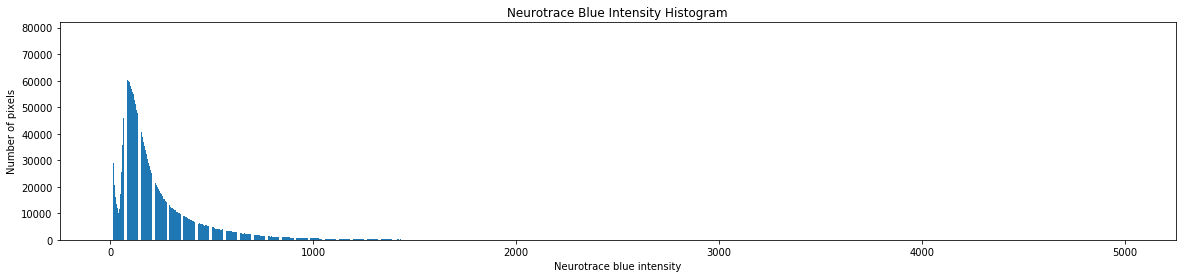

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


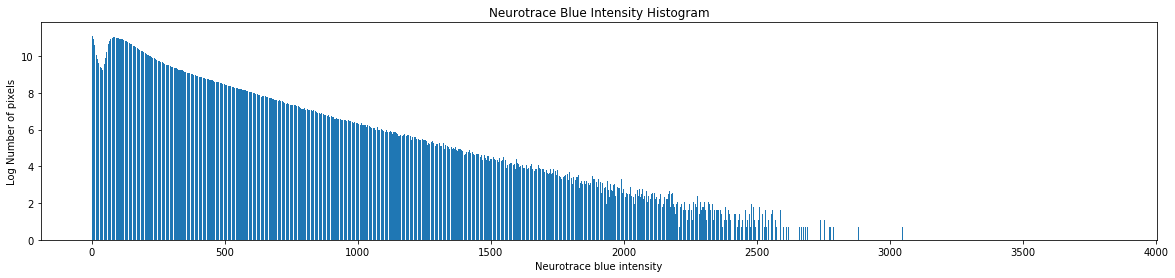

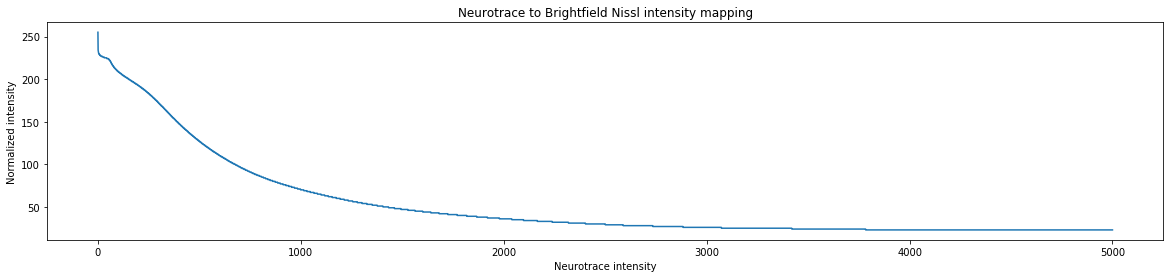

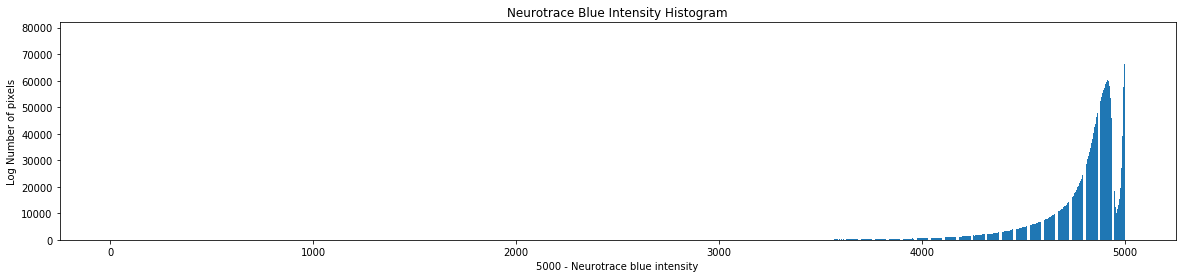

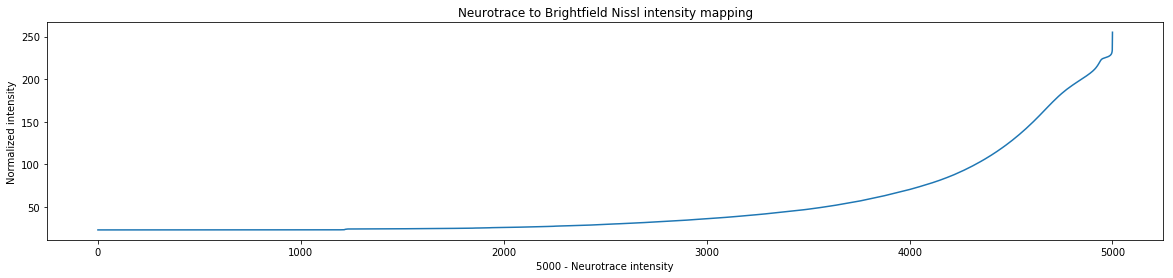

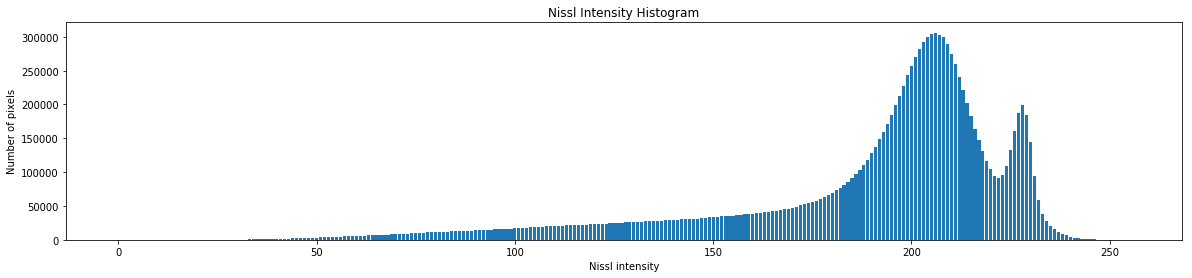

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log


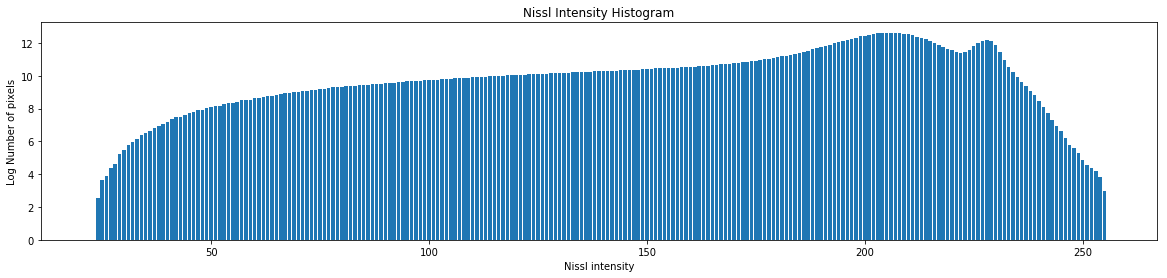

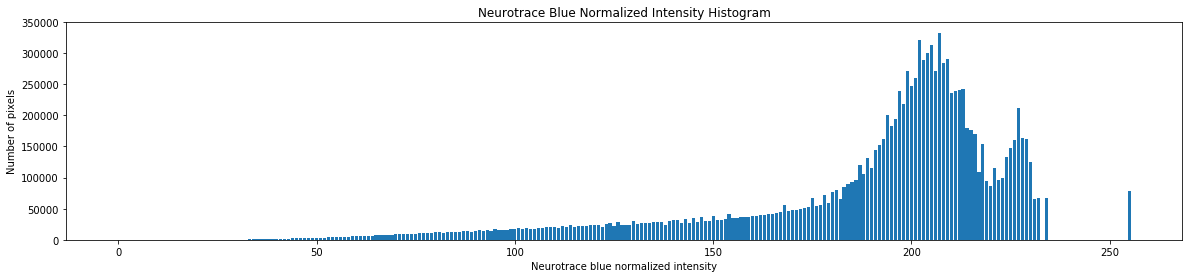

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log


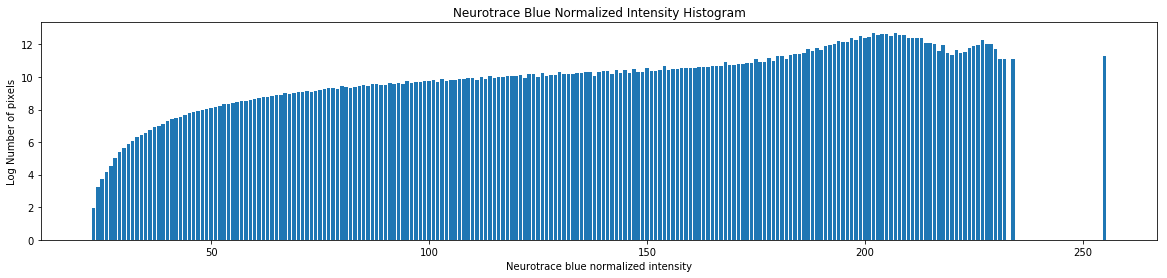

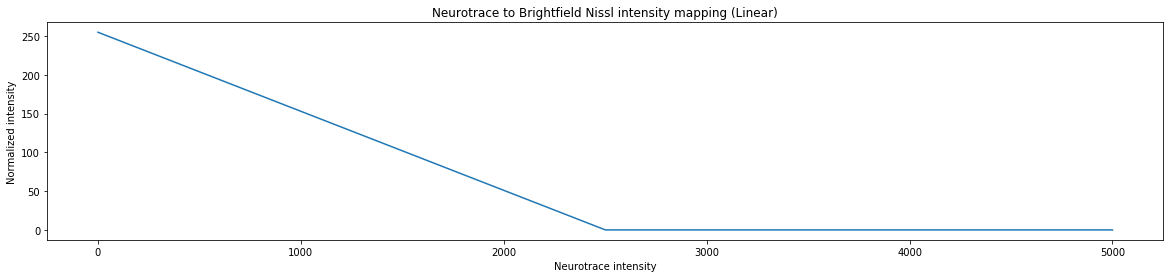

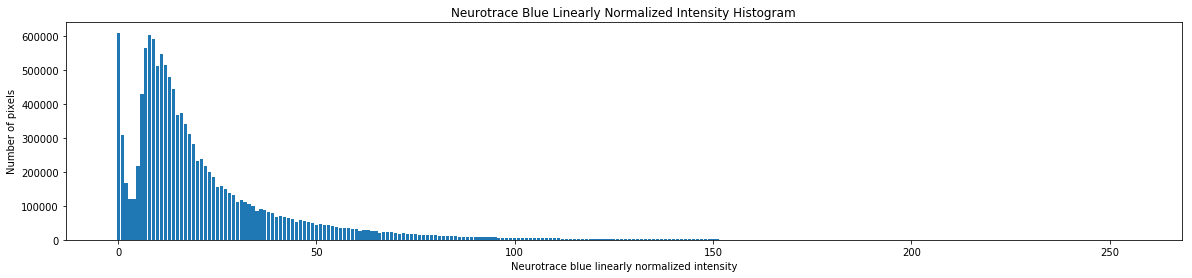

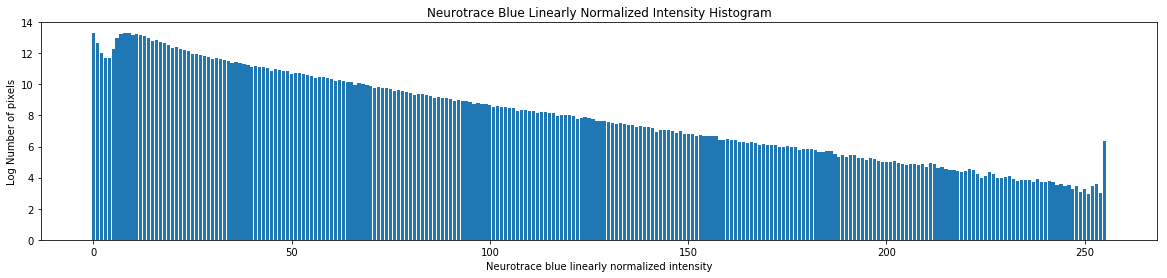

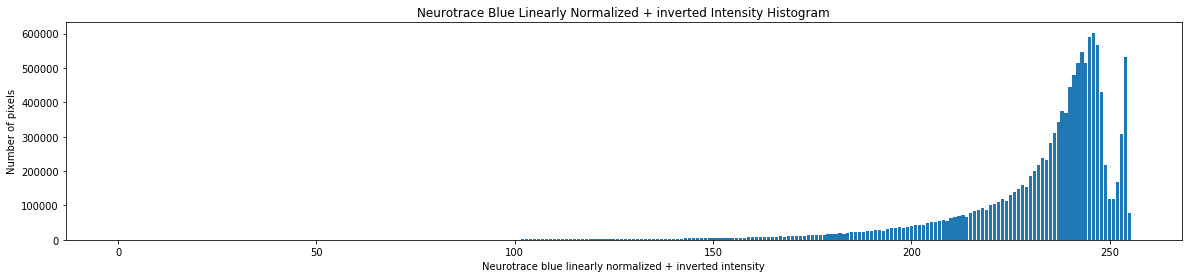

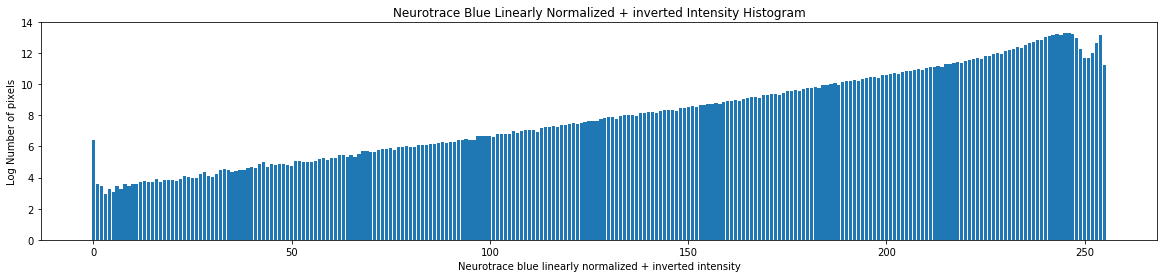

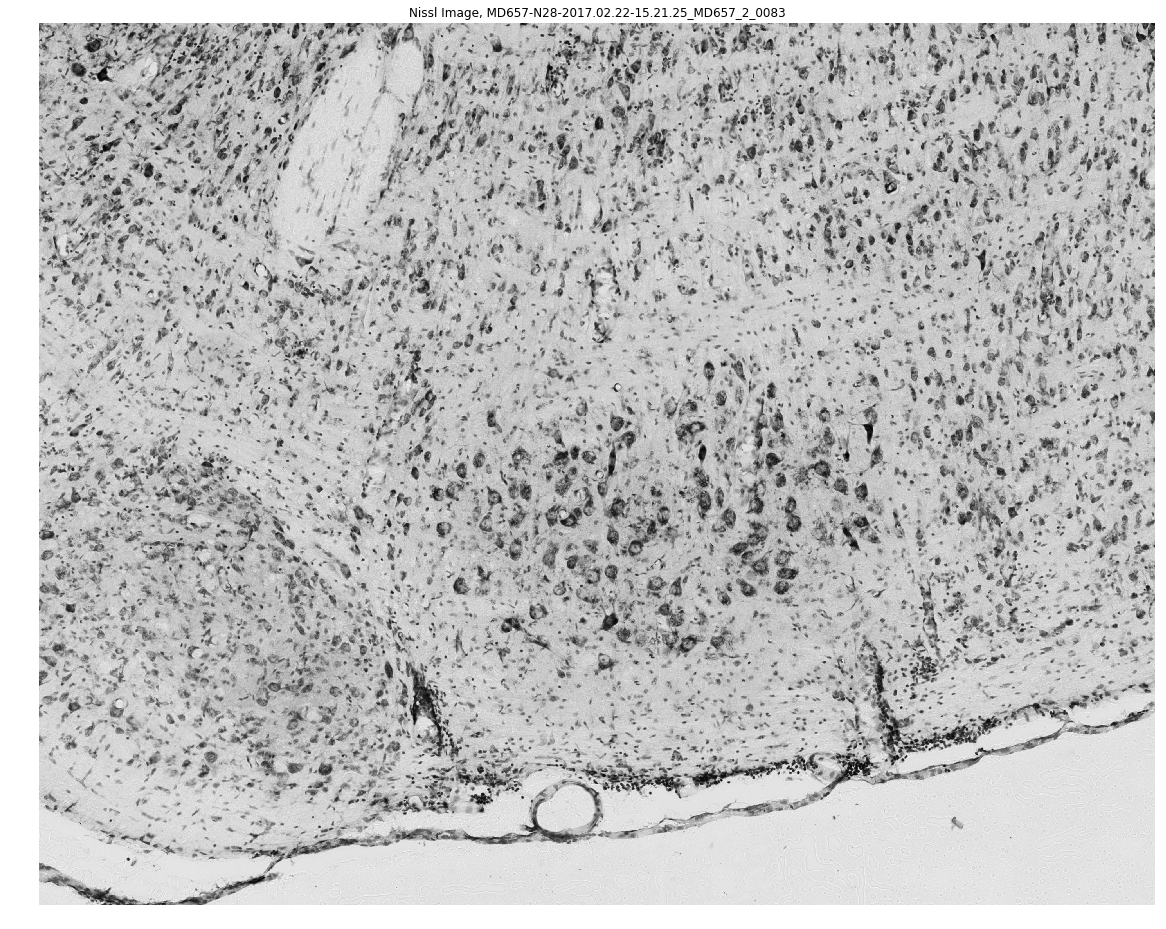

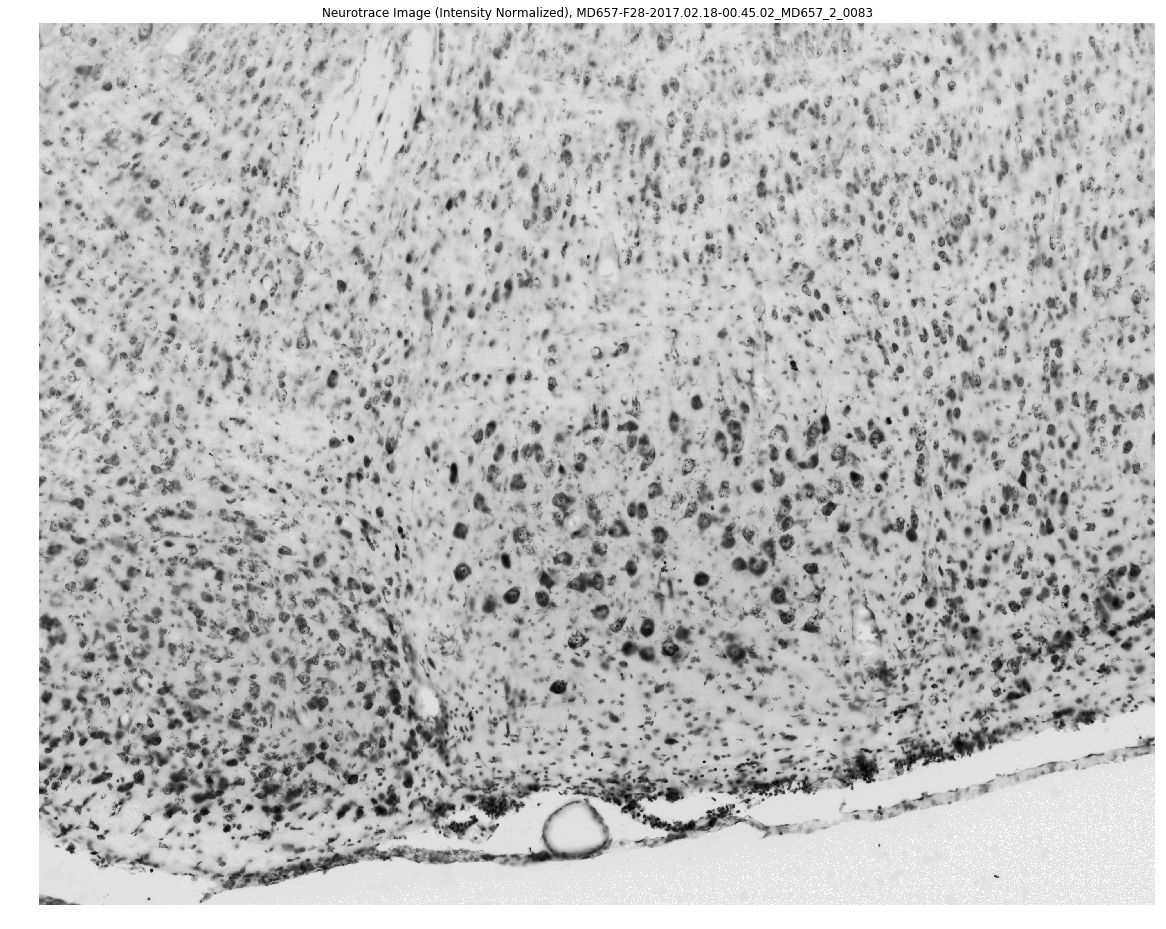

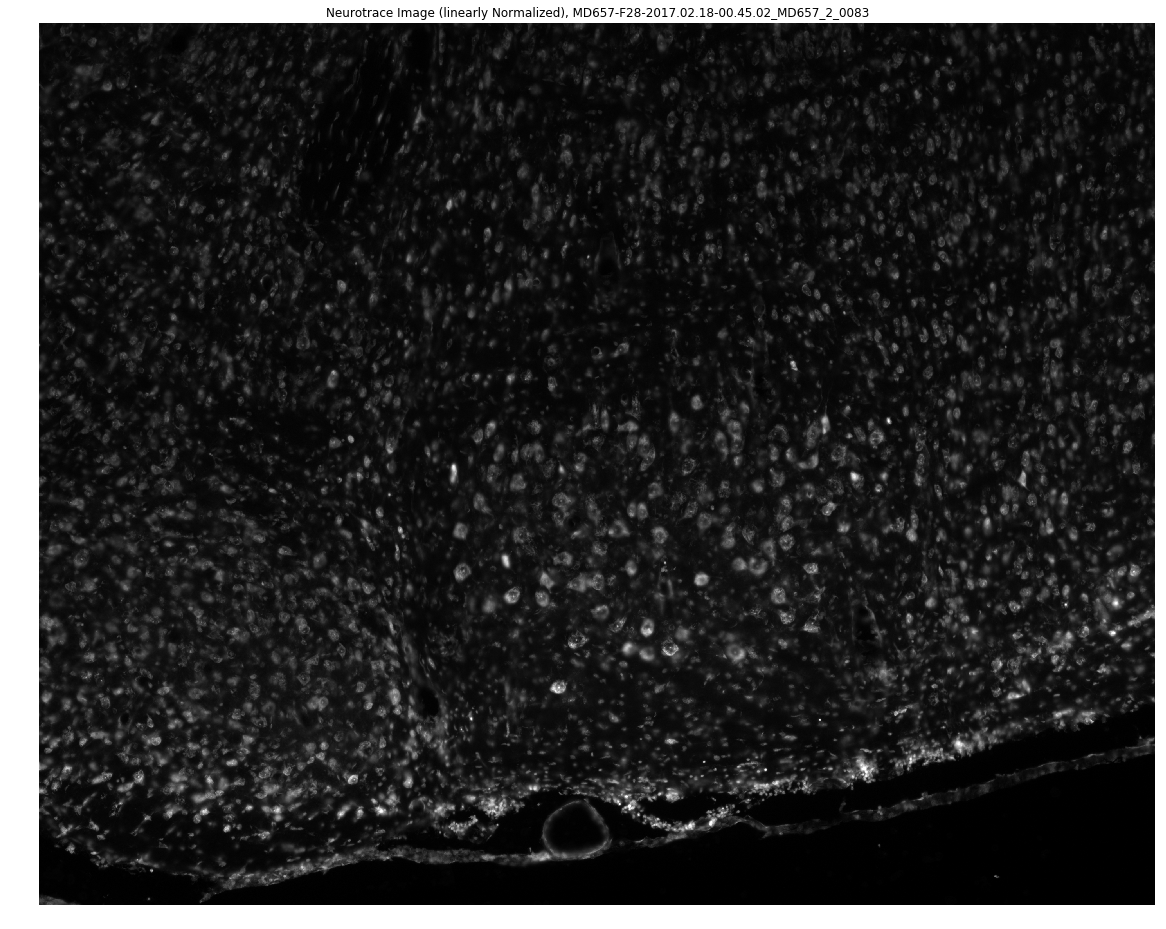

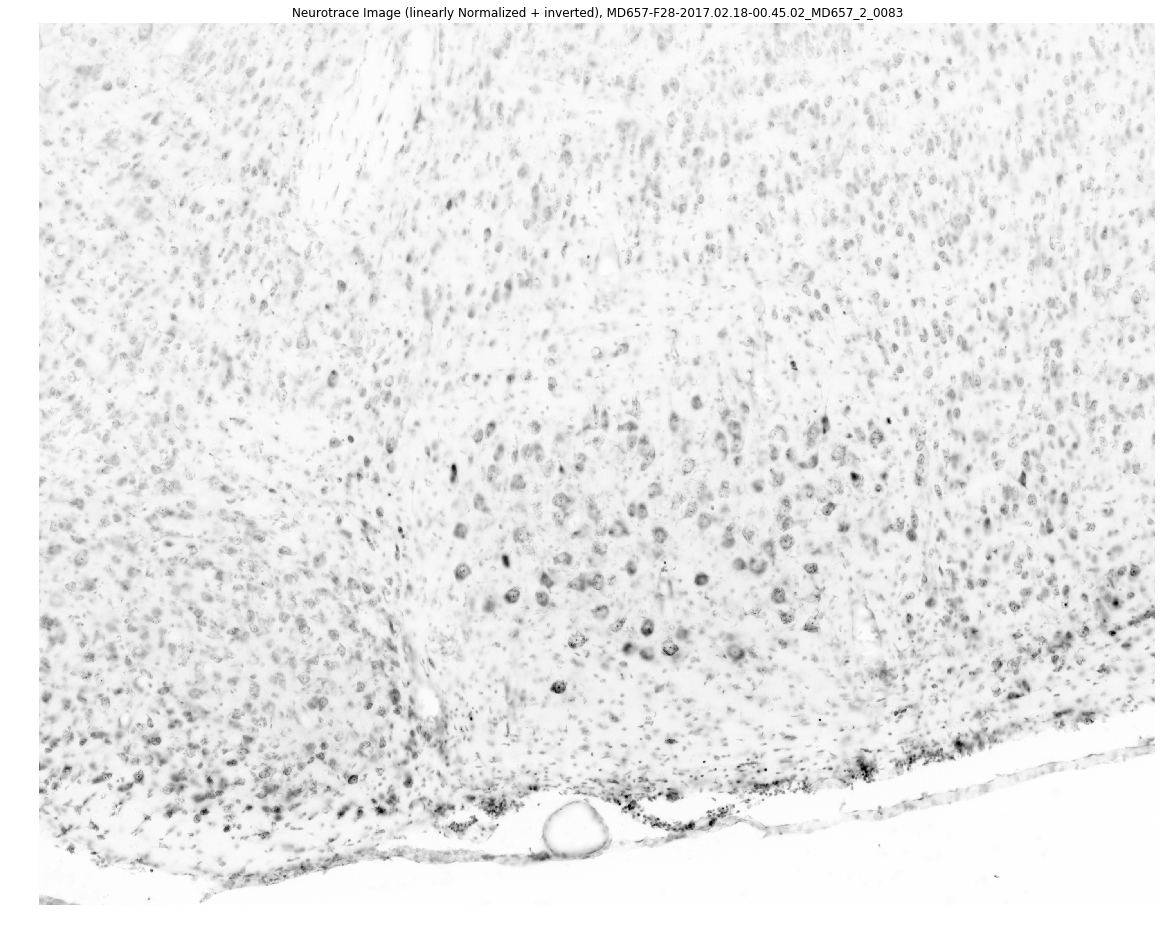

In [29]:
plt.figure(figsize=(20,4));
plt.bar(ntb_blue_bins, ntb_blue_hist);
plt.xlabel('Neurotrace blue intensity');
plt.ylabel('Number of pixels');
plt.title('Neurotrace Blue Intensity Histogram');
plt.show();

plt.figure(figsize=(20,4));
plt.bar(ntb_blue_bins, np.log(ntb_blue_hist));
plt.xlabel('Neurotrace blue intensity');
plt.ylabel('Log Number of pixels');
plt.title('Neurotrace Blue Intensity Histogram');
plt.show();

plt.figure(figsize=(20,4));
plt.plot(ntb_blue_bins, ntb_to_nissl_mapping);
plt.xlabel('Neurotrace intensity');
plt.ylabel('Normalized intensity');
plt.title('Neurotrace to Brightfield Nissl intensity mapping');
plt.show();

plt.figure(figsize=(20,4));
plt.bar(ntb_blue_inv_bins, ntb_blue_inv_hist);
plt.xlabel('5000 - Neurotrace blue intensity');
plt.ylabel('Log Number of pixels');
plt.title('Neurotrace Blue Intensity Histogram');
plt.show();

plt.figure(figsize=(20,4));
plt.plot(ntb_blue_inv_bins, ntb_inv_to_nissl_mapping);
plt.xlabel('5000 - Neurotrace intensity');
plt.ylabel('Normalized intensity');
plt.title('Neurotrace to Brightfield Nissl intensity mapping');
plt.show();

plt.figure(figsize=(20,4));
plt.bar(nissl_gray_bins[:-1], nissl_gray_hist);
plt.xlabel('Nissl intensity');
plt.ylabel('Number of pixels');
plt.title('Nissl Intensity Histogram');
plt.show();

plt.figure(figsize=(20,4));
plt.bar(nissl_gray_bins[:-1], np.log(nissl_gray_hist));
plt.xlabel('Nissl intensity');
plt.ylabel('Log Number of pixels');
plt.title('Nissl Intensity Histogram');
plt.show();

plt.figure(figsize=(20,4));
plt.bar(ntb_blue_normalized_bins, ntb_blue_normalized_hist);
plt.xlabel('Neurotrace blue normalized intensity');
plt.ylabel('Number of pixels');
plt.title('Neurotrace Blue Normalized Intensity Histogram');
plt.show();

plt.figure(figsize=(20,4));
plt.bar(ntb_blue_normalized_bins, np.log(ntb_blue_normalized_hist));
plt.xlabel('Neurotrace blue normalized intensity');
plt.ylabel('Log Number of pixels');
plt.title('Neurotrace Blue Normalized Intensity Histogram');
plt.show();

plt.figure(figsize=(20,4));
plt.plot(ntb_blue_bins, ntb_to_nissl_linear_mapping);
plt.xlabel('Neurotrace intensity');
plt.ylabel('Normalized intensity');
plt.title('Neurotrace to Brightfield Nissl intensity mapping (Linear)');
plt.show();


plt.figure(figsize=(20,4));
plt.bar(ntb_blue_linearNormalized_bins, ntb_blue_linearNormalized_hist);
plt.xlabel('Neurotrace blue linearly normalized intensity');
plt.ylabel('Number of pixels');
plt.title('Neurotrace Blue Linearly Normalized Intensity Histogram');
plt.show();

plt.figure(figsize=(20,4));
plt.bar(ntb_blue_linearNormalized_bins, np.log(ntb_blue_linearNormalized_hist));
plt.xlabel('Neurotrace blue linearly normalized intensity');
plt.ylabel('Log Number of pixels');
plt.title('Neurotrace Blue Linearly Normalized Intensity Histogram');
plt.show();


plt.figure(figsize=(20,4));
plt.bar(ntb_blue_linearNormalized_inverted_bins, ntb_blue_linearNormalized_inverted_hist);
plt.xlabel('Neurotrace blue linearly normalized + inverted intensity');
plt.ylabel('Number of pixels');
plt.title('Neurotrace Blue Linearly Normalized + inverted Intensity Histogram');
plt.show();

plt.figure(figsize=(20,4));
plt.bar(ntb_blue_linearNormalized_inverted_bins, np.log(ntb_blue_linearNormalized_inverted_hist));
plt.xlabel('Neurotrace blue linearly normalized + inverted intensity');
plt.ylabel('Log Number of pixels');
plt.title('Neurotrace Blue Linearly Normalized + inverted Intensity Histogram');
plt.show();      


# Separate Figures

plt.figure(figsize=(20,20));
plt.imshow(nissl_region1, plt.cm.gray);
plt.title('Nissl Image, %s' % metadata_cache['sections_to_filenames'][stack][nissl_sec]);
plt.axis('off');
plt.show();

plt.figure(figsize=(20,20));
plt.imshow(ntb_region1_normalized, plt.cm.gray);
plt.title('Neurotrace Image (Intensity Normalized), %s' % metadata_cache['sections_to_filenames'][stack][ntb_sec]);
plt.axis('off');
plt.show();

plt.figure(figsize=(20,20));
plt.imshow(ntb_region1_linearNormalized, plt.cm.gray);
plt.title('Neurotrace Image (linearly Normalized), %s' % metadata_cache['sections_to_filenames'][stack][ntb_sec]);
plt.axis('off');
plt.show();

plt.figure(figsize=(20,20));
plt.imshow(ntb_region1_linearNormalized_inverted, plt.cm.gray);
plt.title('Neurotrace Image (linearly Normalized + inverted), %s' % metadata_cache['sections_to_filenames'][stack][ntb_sec]);
plt.axis('off');
plt.show();


# Subplots
#         fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,10));
#         axes[0].imshow(nissl_region1, plt.cm.gray);
#         axes[0].set_title('Nissl');
#         axes[0].axis('off');

#         axes[1].imshow(ntb_region1_inv_normalized, plt.cm.gray);
#         axes[1].set_title('Neurotrace (intensity normalized)');
#         axes[1].axis('off');

#         axes[2].imshow(ntb_region1_inv_linearNormalized, plt.cm.gray);
#         axes[2].set_title('Neurotrace (linearly normalized)');
#         axes[2].axis('off');
#         plt.show();